In [ ]:
# !pip install pytesseract

In [13]:
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import pytesseract
import os

In [14]:
# pytesseract.pytesseract.tesseract_cmd = 'C:/OCR/Tesseract-OCR/tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

In [15]:

def preprocess(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply image enhancement techniques (e.g., histogram equalization)
    enhanced_image = cv2.equalizeHist(gray)
    
    # Apply noise reduction techniques (e.g., median blur)
    smooth_image = cv2.medianBlur(enhanced_image, 3)
    
    # Binarize the image (e.g., using Otsu's thresholding)
    _, binary_image = cv2.threshold(smooth_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binary_image


In [16]:
# def segment_captcha(image):
#   # Find connected components in the image
#   nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)

#   # Find the width and height of each component
#   sizes = stats[:, -1]
#   min_size = max(sizes) // 10
#   max_size = max(sizes)

#   # Create an empty list to store the segmented characters
#   characters = []

#   # Loop through all connected components
#   for i in range(1, nb_components):
#     # Check if the component is small enough to be a character
#     if sizes[i] < min_size or sizes[i] > max_size:
#       continue

#     # Get the bounding box of the component
#     x, y, w, h = stats[i, :4]
#     characters.append(image[y:y+h, x:x+w])
  
#   return characters

In [17]:
import cv2
import matplotlib.pyplot as plt

def segment_captcha(image):
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  plt.imshow(gray, cmap='gray')
  plt.title("Grayscale image")
  plt.show()

  # Blur the image to reduce noise
  blur = cv2.GaussianBlur(gray, (5, 5), 0)
  plt.imshow(blur, cmap='gray')
  plt.title("Blurred image")
  plt.show()

  # Threshold the image to create a binary image
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  plt.imshow(thresh, cmap='gray')
  plt.title("Thresholded image")
  plt.show()

  # Find the contours of the characters in the image
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

  # Sort the contours by their x-coordinates
  contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

  # Initialize an empty list to store the characters
  characters = []

  # Loop through the contours
  for c in contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(c)

    # Check if the contour is a character
    if w > 15 and h > 30:
      # Crop the character from the image
      char_image = gray[y:y+h, x:x+w]

      # Add the character to the list
      characters.append(char_image)

      # Display the character image
      plt.imshow(char_image, cmap='gray')
      plt.title("Segmented character")
      plt.show()

  return characters


In [18]:
def recognize_text(characters):
  # Create an empty list to store the recognized text
  recognized_text = []

  # Loop through each character
  for character in characters:
    # Use Tesseract to recognize the text in the character image
    text = pytesseract.image_to_string(character, lang='eng', config='--psm 10')

    # Add the recognized text to the list
    recognized_text.append(text)
  
  return recognized_text


In [19]:
import re

def post_process(text):
  # Remove any non-alphabetic characters from the text
  text = re.sub(r'[^a-zA-Z]', '', text)

  # Convert the text to lowercase
  text = text.lower()
  
  return text


In [20]:
import cv2
import matplotlib.pyplot as plt

def display_captcha(image, text):
  # Display the image
  plt.imshow(image, cmap='gray')
  plt.axis('off')

  # Display the text above the image
  plt.title(text)
  plt.show()


In [21]:

def create_dataframe(images):
  # Create an empty list to store the processed text for each image
  processed_text = []

  # Loop through the images
  for i in range(len(images)):
    # Pre-process and segment the image
    preprocessed_image = preprocess(images[i])
    characters = segment_captcha(preprocessed_image)

    # Recognize the text in the image
    recognized_text = recognize_text(characters)
    
    # Apply post-processing to the recognized text
#     processed_text = post_process(recognized_text)
    processed_text = recognized_text
    # Add the processed text to the list
    processed_text.append(processed_text)
  
  # Create a dataframe from the file names and processed text
  df = pd.DataFrame({'Processed Text': processed_text})
  
  return df


In [22]:
def load_images(directory):
  # Create empty lists to store the file names and images
  file_names = []
  images = []

  # Loop through the files in the directory
  for file in os.listdir(directory):
    # Load the image file
    image = cv2.imread(os.path.join(directory, file))

    # Add the file name and image to the lists
    file_names.append(file)
    images.append(image)
  
  return file_names, images


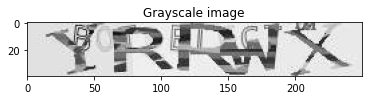

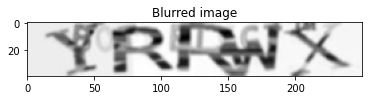

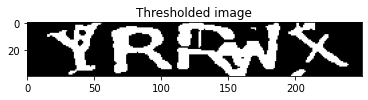

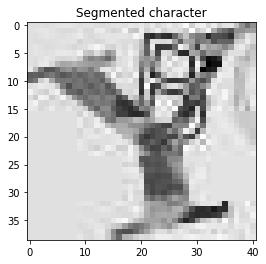

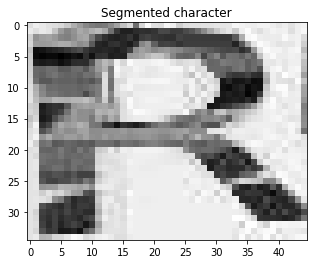

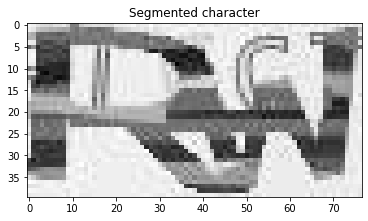

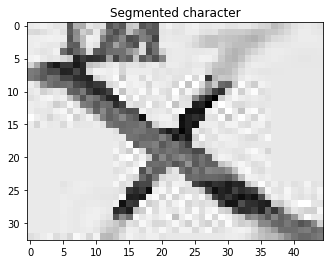

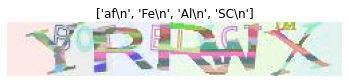

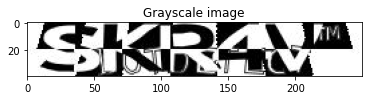

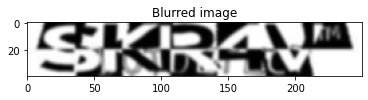

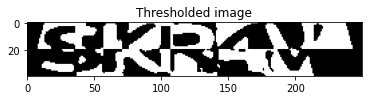

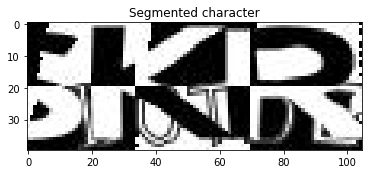

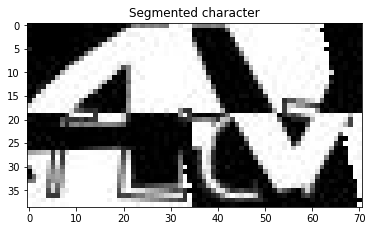

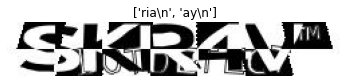

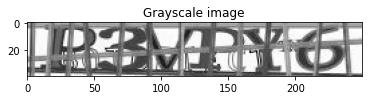

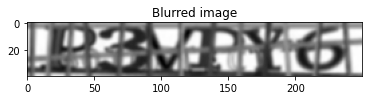

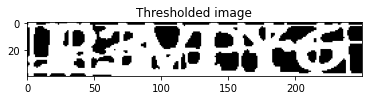

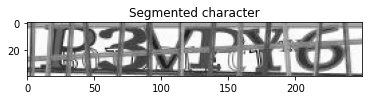

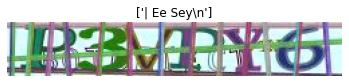

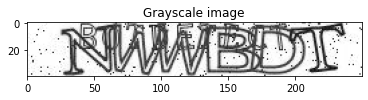

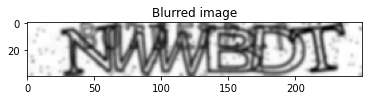

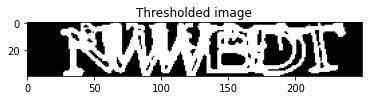

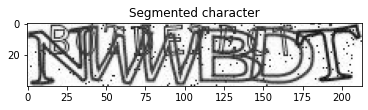

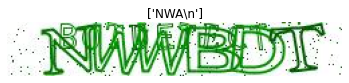

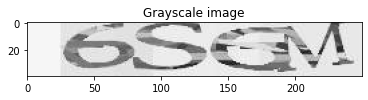

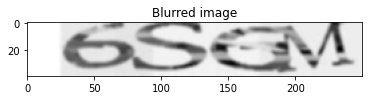

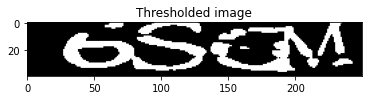

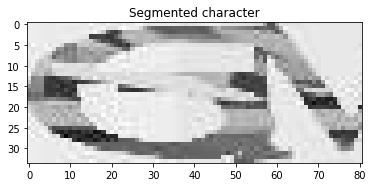

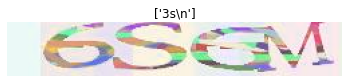

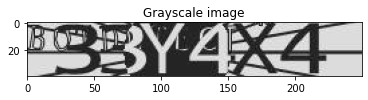

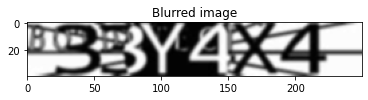

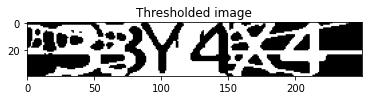

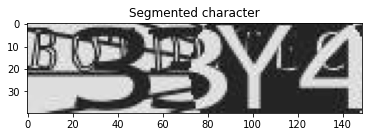

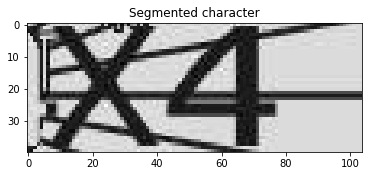

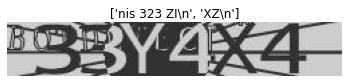

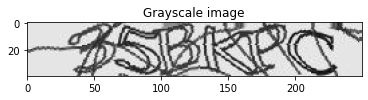

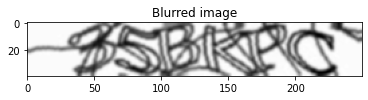

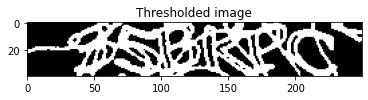

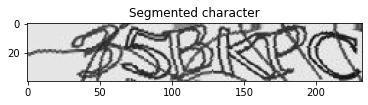

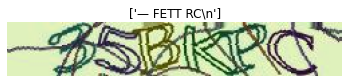

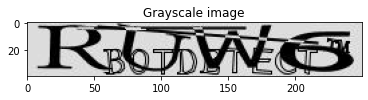

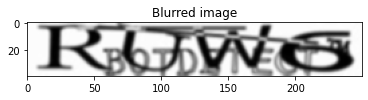

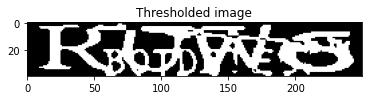

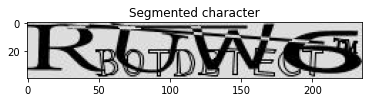

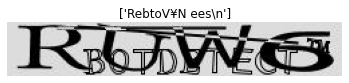

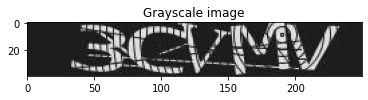

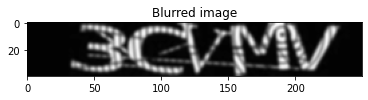

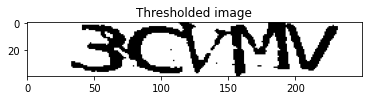

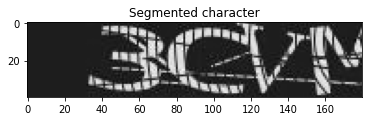

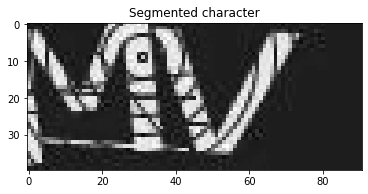

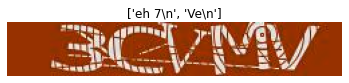

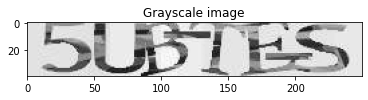

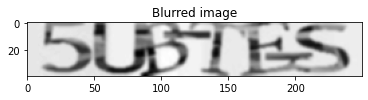

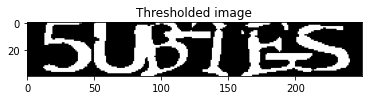

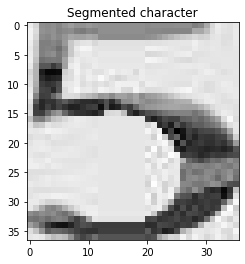

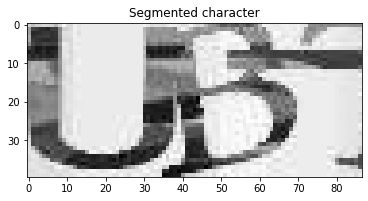

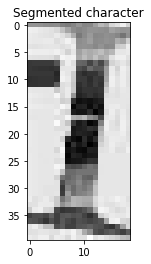

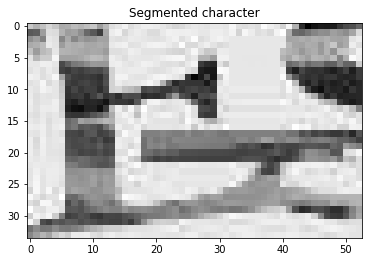

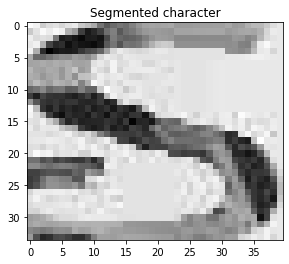

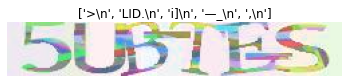

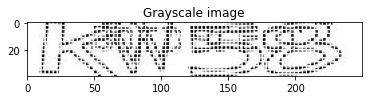

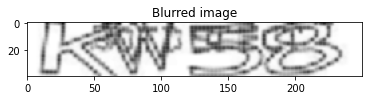

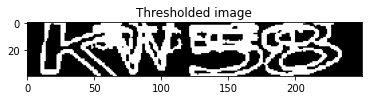

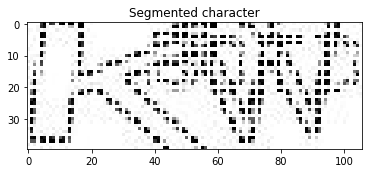

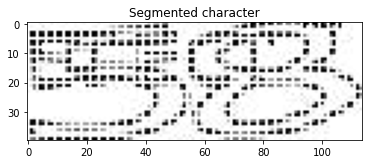

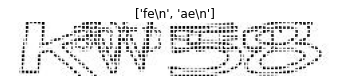

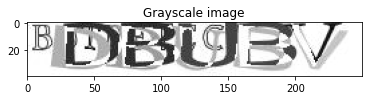

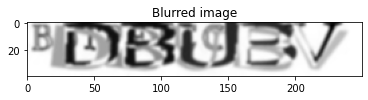

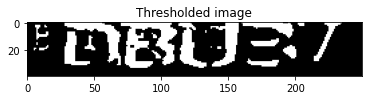

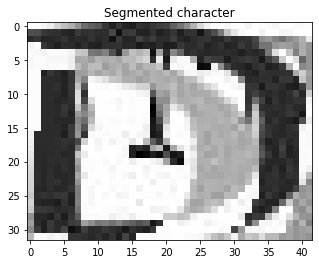

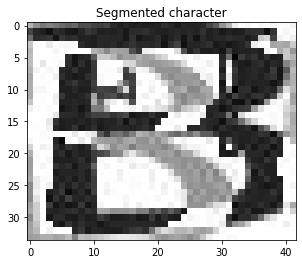

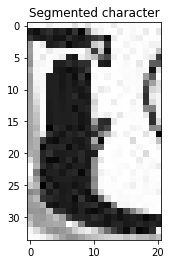

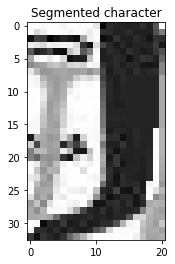

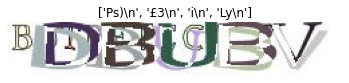

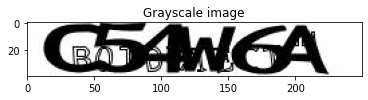

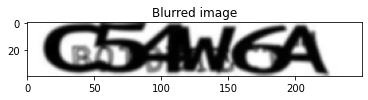

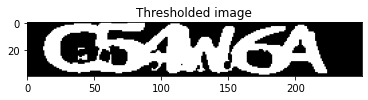

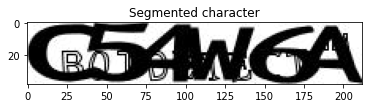

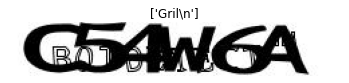

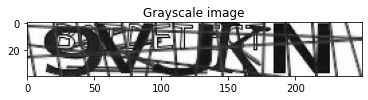

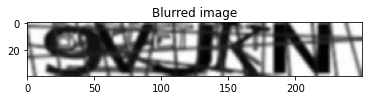

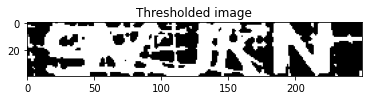

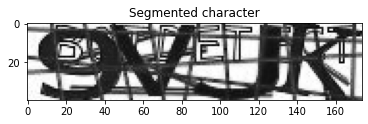

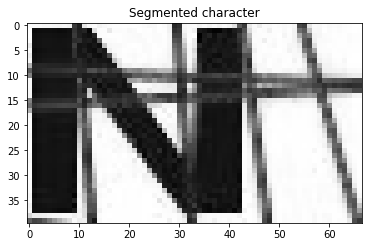

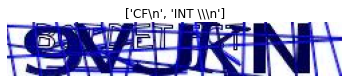

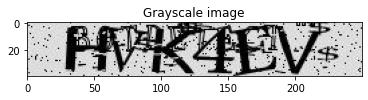

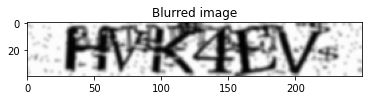

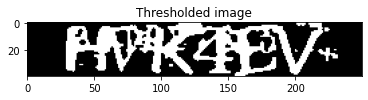

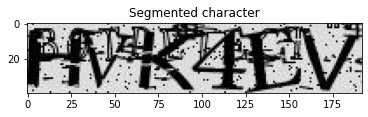

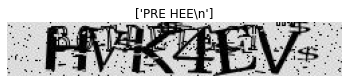

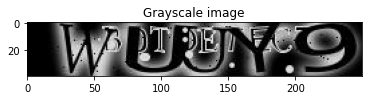

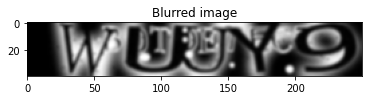

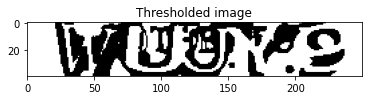

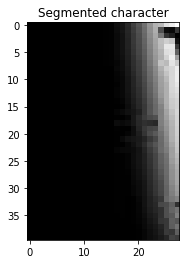

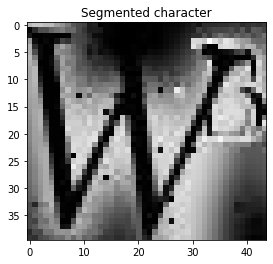

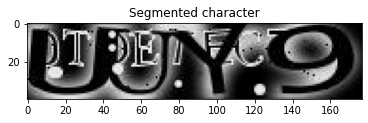

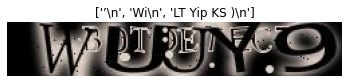

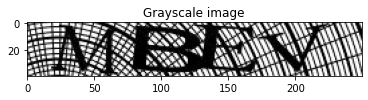

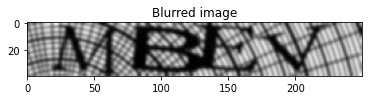

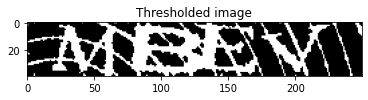

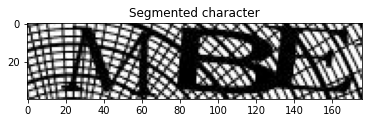

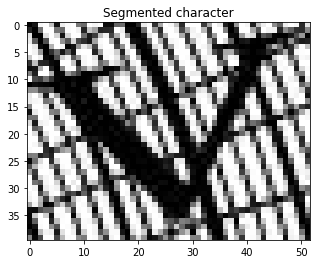

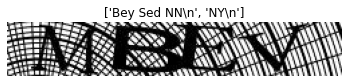

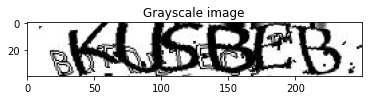

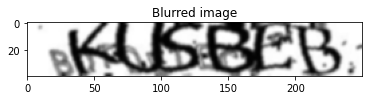

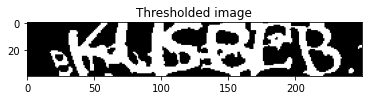

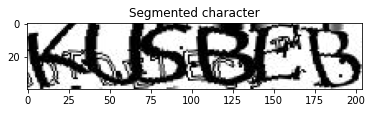

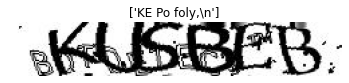

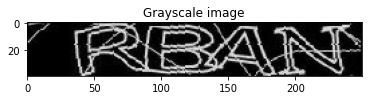

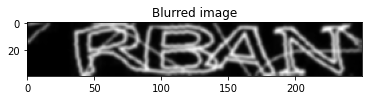

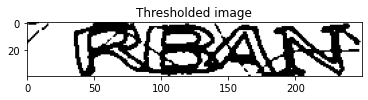

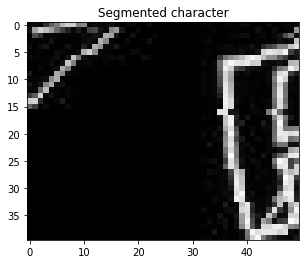

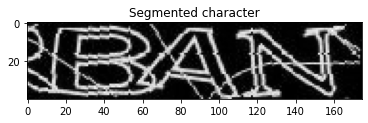

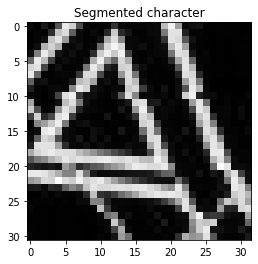

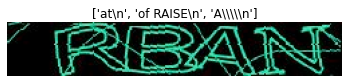

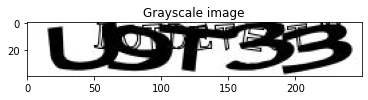

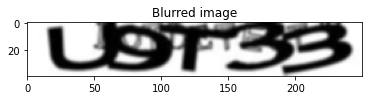

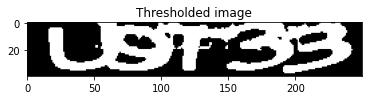

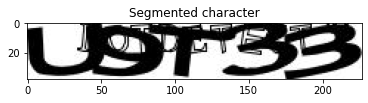

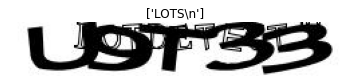

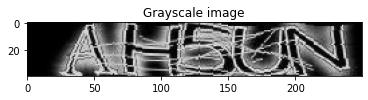

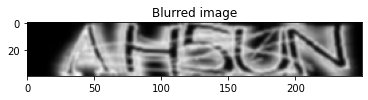

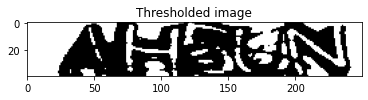

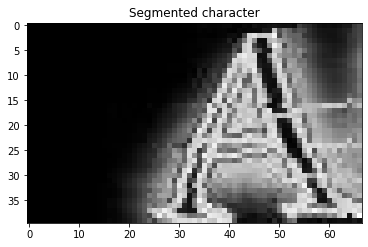

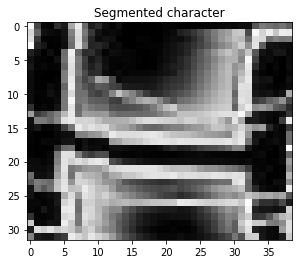

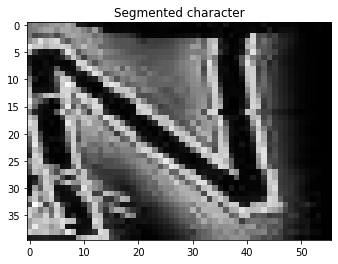

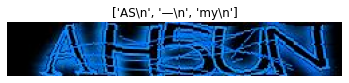

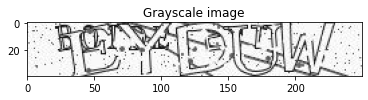

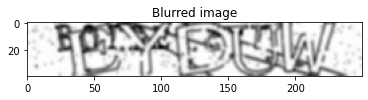

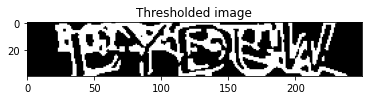

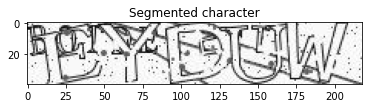

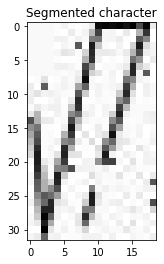

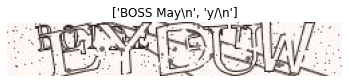

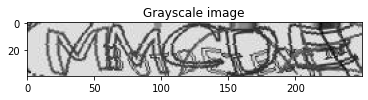

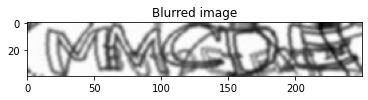

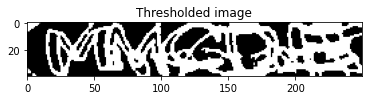

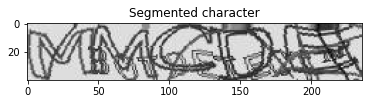

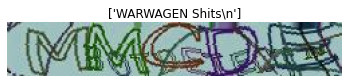

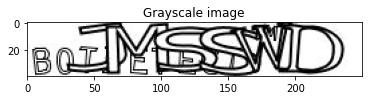

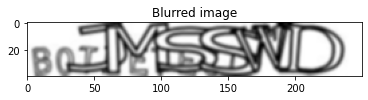

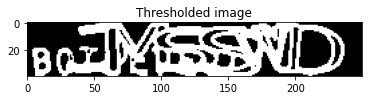

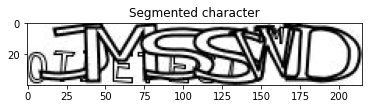

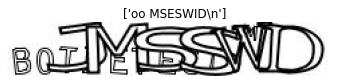

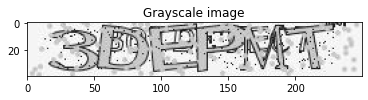

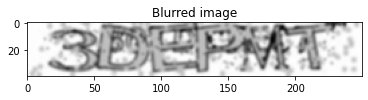

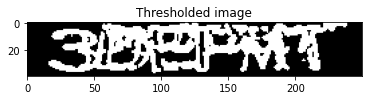

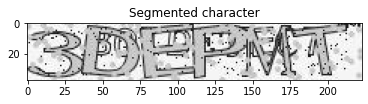

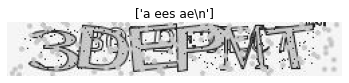

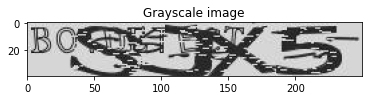

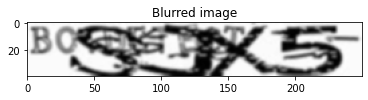

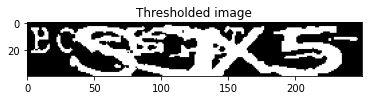

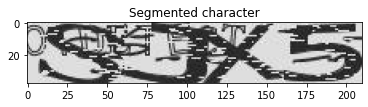

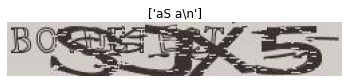

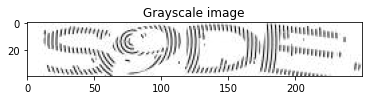

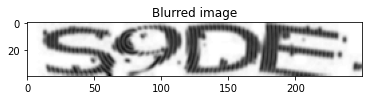

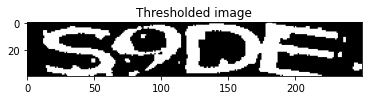

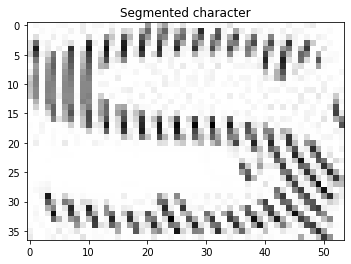

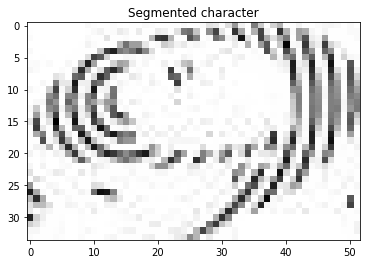

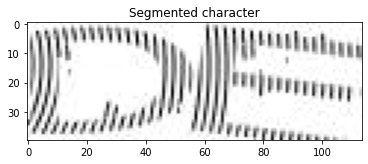

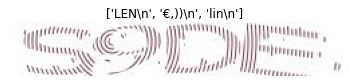

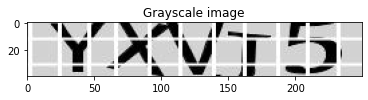

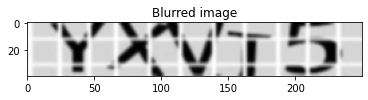

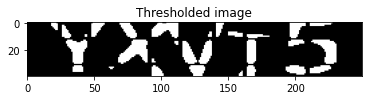

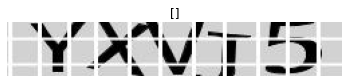

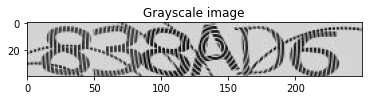

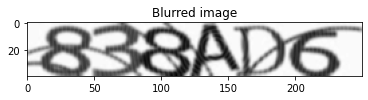

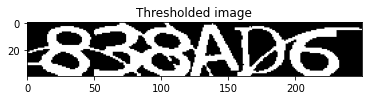

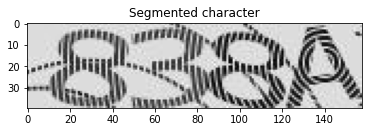

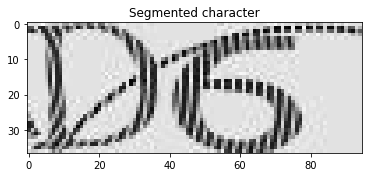

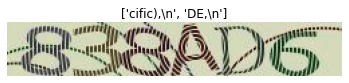

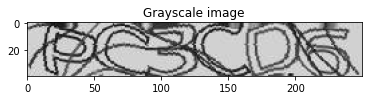

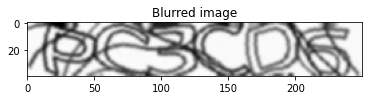

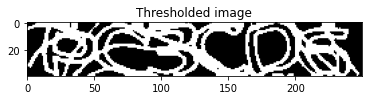

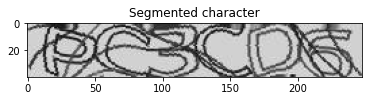

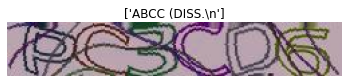

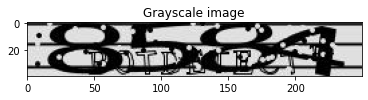

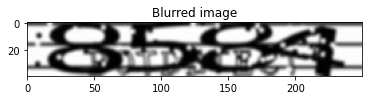

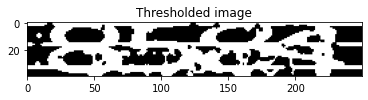

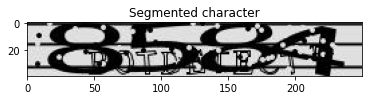

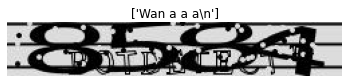

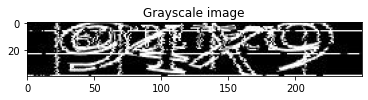

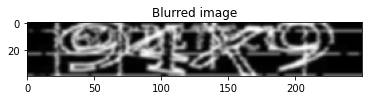

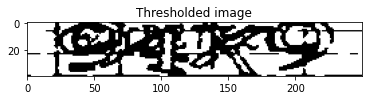

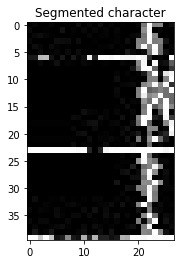

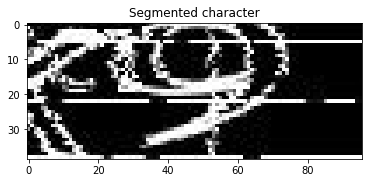

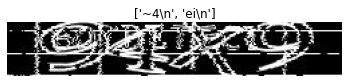

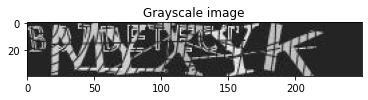

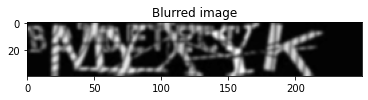

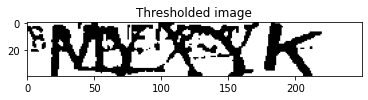

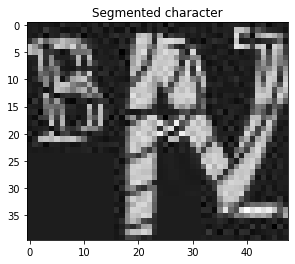

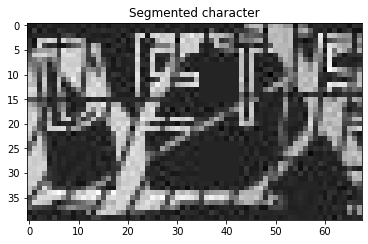

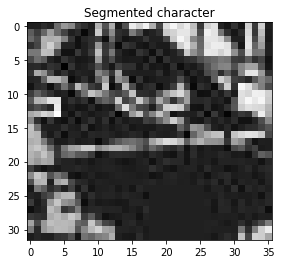

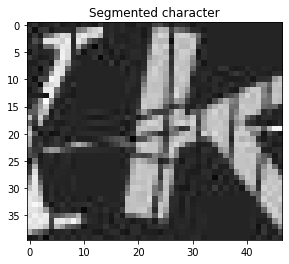

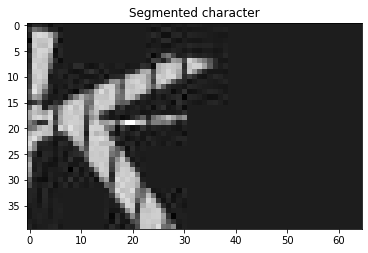

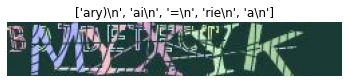

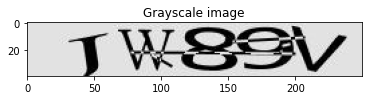

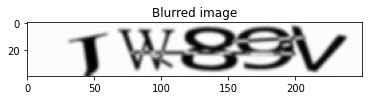

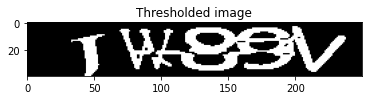

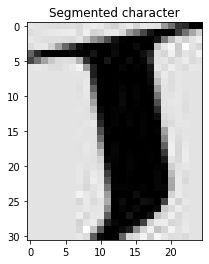

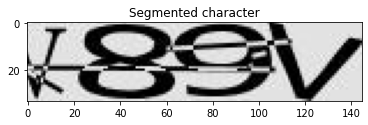

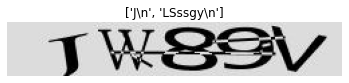

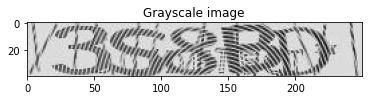

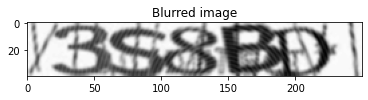

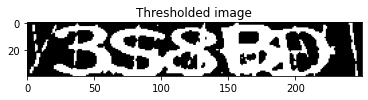

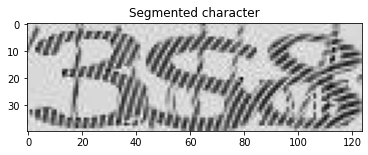

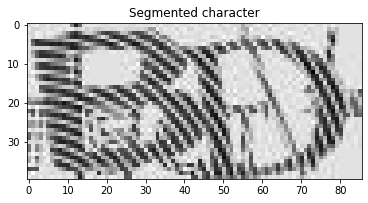

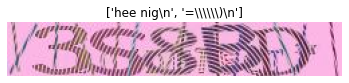

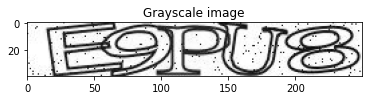

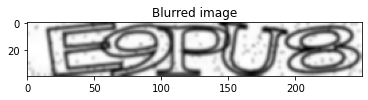

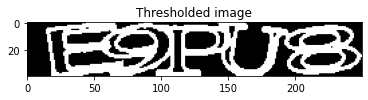

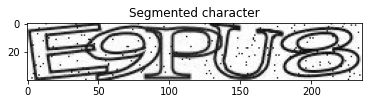

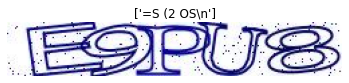

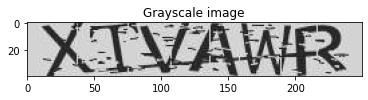

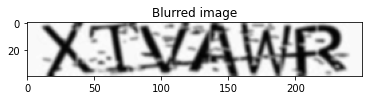

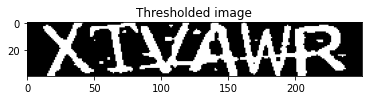

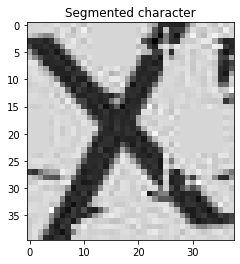

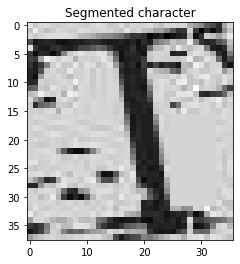

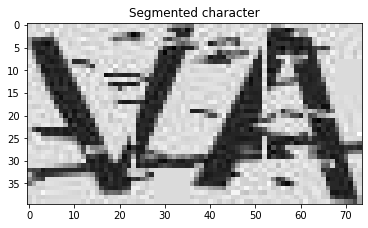

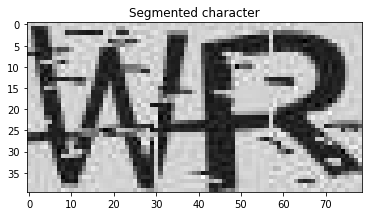

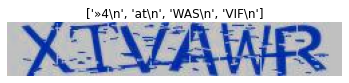

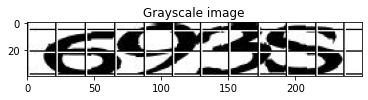

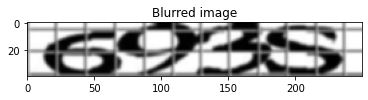

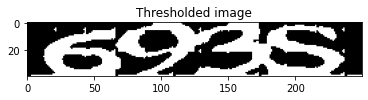

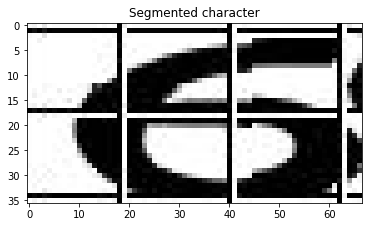

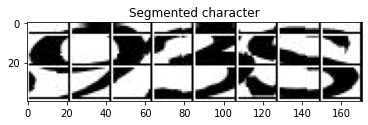

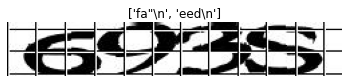

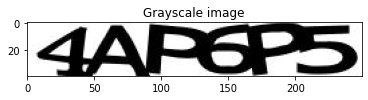

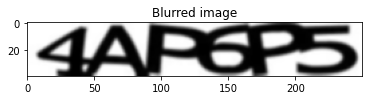

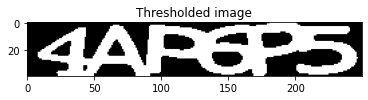

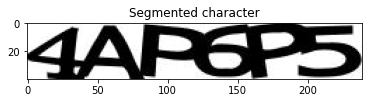

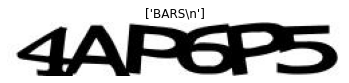

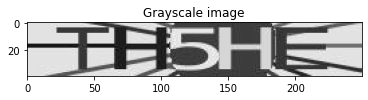

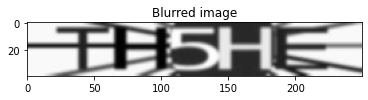

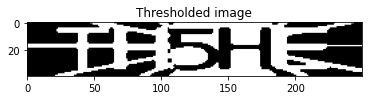

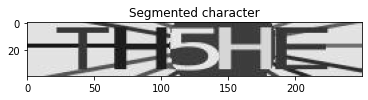

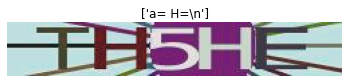

In [23]:
# Load the images
images = []
for i in range(1, 41):
    image = cv2.imread(f'Sample_Images/botdetectcaptcha ({i}).jpg')
#     preprocessed_image = preprocess(image)
    characters = segment_captcha(image)
    text = recognize_text(characters)
    display_captcha(image, text)


# file_names, images = load_images('Sample_Images')
# df = create_dataframe(images)


In [ ]:
# file_names


In [ ]:
def extract_features(characters):
  # Create an empty list to store the features
  features = []

  # Loop through each character
  for character in characters:
    # Calculate the aspect ratio of the character
    aspect_ratio = character.shape[1] / character.shape[0]

    # Calculate the vertical and horizontal projections of the character
    vertical_projection = np.sum(character, axis=0)
    horizontal_projection = np.sum(character, axis=1)

    # Calculate the number of black pixels in the character
    black_pixels = np.sum(character == 0)

    # Calculate the moments of the character
    moments = cv2.moments(character)
    hu_moments = cv2.HuMoments(moments)

    # Append the calculated features to the list
    features.append([aspect_ratio, vertical_projection, horizontal_projection, black_pixels, hu_moments])
  
  return features


In [ ]:
# def classify_captcha(features, labels):
#   # Create an SVM classifier
#   clf = SVC(kernel='linear')

#   # Train the classifier on the features and labels
#   clf.fit(features, labels)
  
#   return clf


In [ ]:
# # Pre-process the images
# preprocessed_images = []
# for image in images:
#     preprocessed_image = preprocess(image)
#     characters = segment_captcha(preprocessed_image)
#     recognized_text = recognize_text(characters)

# #     features = extract_features(characters)
# #     predicted_labels = clf.predict(features)

#     preprocessed_images.append(preprocessed_image)


In [ ]:
# images

In [ ]:
# preprocessed_image